TokaMaker Meshing Example: Building a mesh with toroidally non-continuous conductors for LTX {#doc_tMaker_LTX_ex1}
==========
In this example we show how to generate a mesh with toroidally non-continuous conductors for the LTX-&beta; device using TokaMakers built in mesh generation.

**Warning:** Toroidally non-continuous conducting regions are still in development. Please be careful when using this feature and report any issues.

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) and [h5py](https://www.h5py.org/) python packages. Both of which are installable using `pip` or other standard methods.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh

# Build mesh

## Set mesh resolution for each region
First we define some target sizes to set the resolution in out grid. These variables will be used later and represent the target edge size within a given region, where units are in meters. In this case we are using a fairly coarse resolution of 2 cm in the plasma region and 5 cm in the vacuum region. Note that when setting up a new machine these values will need to scale with the overall size of the device/domain. Additionally, one should perform a convergence study, by increasing resolution (decreasing target size) by at least a factor of two in all regions to ensure the results are not sensitive to your choice of grid size.

In [3]:
plasma_dx = 0.02
coil_dx = 0.02
vv_dx = 0.015
vac_dx = 0.05

## Load geometry information
The geometry information (eg. bounding curves for vacuum vessels) are now loaded from a JSON file. This JSON file contains the following:
 - `limiter`: A contour of R,Z points defining the limiter surface (inner side of shell, bridged at the midplane at the back side)
 - `shell`: A contour of R,Z points defining the a single shell segment (upper)
 - `vv`: A set of contours defining the vacuum vessel. Multiple regions are used to specify different resistivity where ports are placed.
 - `coils`: A dictionary of R,Z,W,H values defining the PF coils as rectangles in the poloidal cross-section

A JSON is a good way to store common device information that will be reused many times. For simple geometries, testing, or generative usage this can be created directly in the code.

In [4]:
with open('LTX_geom.json','r') as fid:
    LTX_geom = json.load(fid)

## Define regions and attributes
We now create and define the various logical mesh regions. In the LTX-&beta; case we have 5 region groups:
 - `air`: The region outside the plasma limiter. Note that this is one region as this model does not have a connection on the inboard side so the VV is not airtight.
 - `plasma`: The region inside the limiter where the plasma will exist
 - `shellU,shellL`: The upper and lower shell
 - `vv1,vv2,...`: The individual sub-regions that make up the vacuum vessel
 - `OH1,...`: Each of the 17 coils in LTX (5 OH, 12 PF)

For each region you can provide a target size and one of four region types:
 - `plasma`: The region where the plasma can exist and the classic Grad-Shafranov equation with $F*F'$ and $P'$ are allowed. **There can only be one region of this type**
 - `vacuum`: A region where not current can flow and $\nabla^* \psi = 0$ is solved
 - `boundary`: A special case of the `vacuum` region, which forms the outer boundary of the computational domain. **A region of this type is required if more than one region is specified**
 - `conductor`: A region where toroidal current can flow passively (no externally applied voltage). For this type of region the resistivity should be specified with the argument `eta` in units of $\Omega \mathrm{-m}$.
 - `coil`: A region where toroidal current can flow with specified amplitude through `set_coil_currents` or via shape optimization `set_coil_reg` and `set_isoflux`

When defining the upper and lower shell segments we also pass `noncontinuous=True` to indicate that these regions are not toroidal continuous and thus the net toroidal current must be zero. Note that in this case the resistivity (`eta`) should be an effective resistivity that takes into account the toroidal coverage. See \ref doc_tMaker_LTX_ex2 for more information.

In [5]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')
gs_mesh.define_region('plasma',plasma_dx,'plasma')
gs_mesh.define_region('shellU',2*plasma_dx,'conductor',eta=4.E-7,noncontinuous=True)
gs_mesh.define_region('shellL',2*plasma_dx,'conductor',eta=4.E-7,noncontinuous=True)
for i, vv_segment in enumerate(LTX_geom['vv']):
    gs_mesh.define_region('vv{0}'.format(i),2*plasma_dx,'conductor',eta=vv_segment[1])
# Define each of the PF coils
for key, coil in LTX_geom['coils'].items():
    if key.startswith('OH'):
        gs_mesh.define_region(key,coil_dx,'coil',nTurns=coil['nturns'],coil_set='OH')
    else:    
        gs_mesh.define_region(key,coil_dx,'coil',nTurns=coil['nturns'])

## Define geometry for region boundaries
Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.
 1. We add the limiter contour as a "polygon", referencing `plasma` as the region enclosed by the contour and `air` as the region outside the contour.
 2. We add the upper shell as an "polygon" and the lower shell similarly by relfecting the contour. We also reference `air` as the region outside the contour.
 3. We add each of the sub-regions of the VV as "polygon"s and reference `air` as the region outside the contour.
 4. We add each of the 17 coils as "rectangles", which are defined by a center point (R,Z) along with a width (W) and height (H). We also reference `air` as the region outside each region.

In [6]:
# Define geometry
gs_mesh.add_polygon(LTX_geom['limiter'],'plasma',parent_name='air')
gs_mesh.add_polygon(LTX_geom['shell'],'shellU',parent_name='air')
shell_lower = np.array(LTX_geom['shell'].copy()); shell_lower[:,1] *= -1.0
gs_mesh.add_polygon(shell_lower,'shellL',parent_name='air')
for i, vv_segment in enumerate(LTX_geom['vv']):
    gs_mesh.add_polygon(vv_segment[0],'vv{0}'.format(i),parent_name='air')
# Define the shape of the PF coils
for key, coil in LTX_geom['coils'].items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

## Plot topology
After defining the logical and physical topology we can now plot the curves within the definitions to double check everything is in the right place. In cases where curves appear to cross eachother (as with the `OH1` and `GREEN` coils) one should zoom in to ensure no crossings exist. In this case we had to move the `GREEN` coils out by 1.27 cm to avoid an intersection with the `OH1`. Note a similar shift was also applied in the PSI-Tri model.

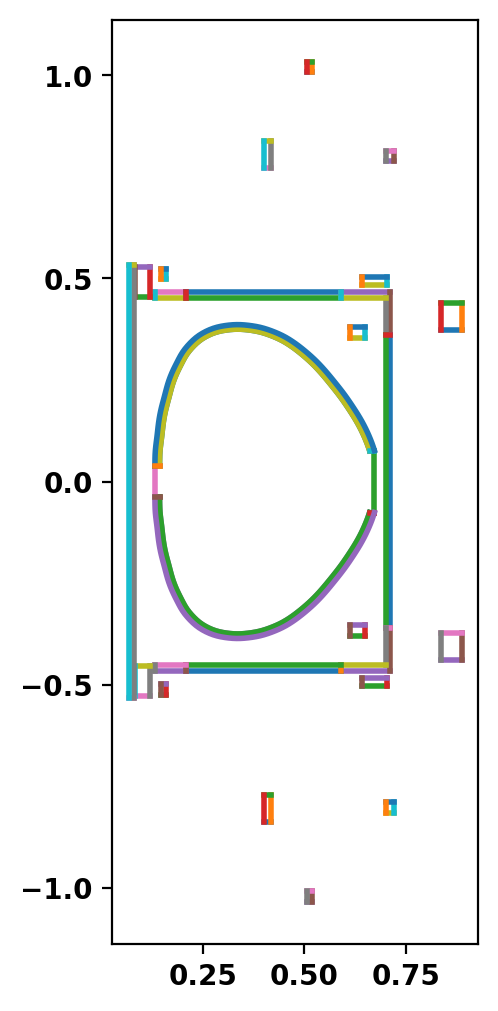

In [7]:
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

## Create mesh
Now we generate the actual mesh using the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.build_mesh "build_mesh()" method. Additionally, if `coil` and/or `conductor` regions are defined the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_coils "get_coils()" and \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_conductors "get_conductors()" methods should also be called to get descriptive dictionaries for later use in TokaMaker. This step may take a few moments as [triangle](https://www.cs.cmu.edu/~quake/triangle.html) generates the mesh.

Note that, as is common with unstructured meshes, the mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,), which is mapped to the names above using the `coil_dict` and `cond_dict` dictionaries.

In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 590
  # of unique segments  = 108
Generating mesh:
  # of points  = 3125
  # of cells   = 6108
  # of regions = 28


## Plot resulting regions and grid
We now plot the mesh by region to inspect proper generation.

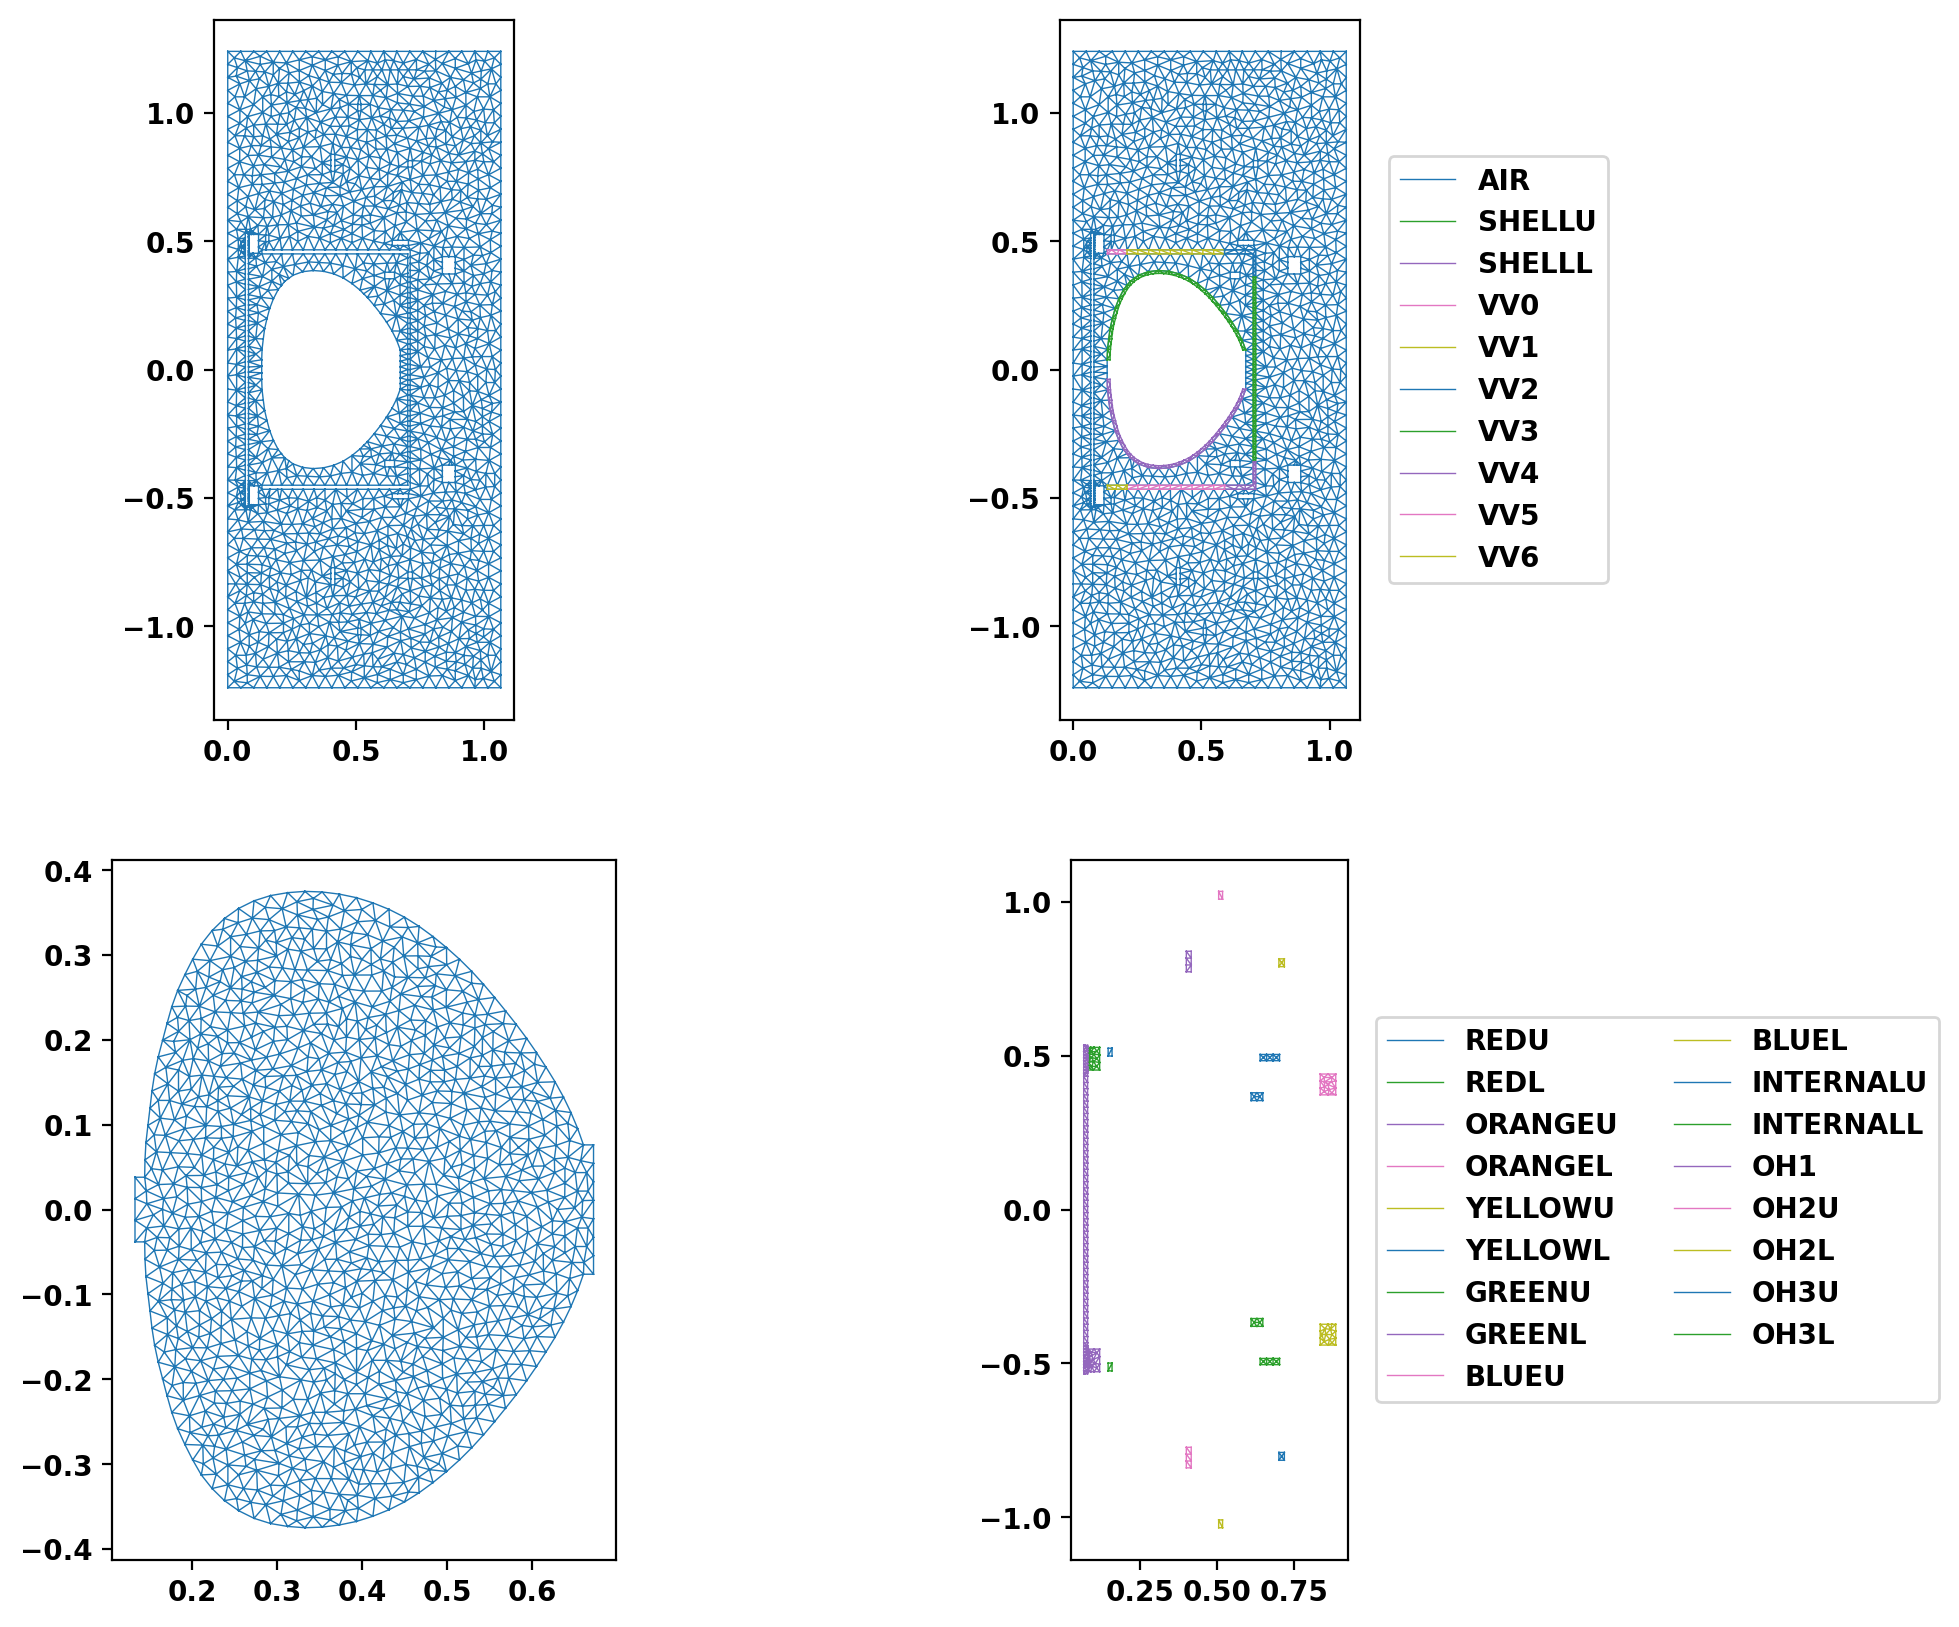

In [9]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==2,:],lw=0.5)
ax[1,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==1,:],lw=0.5)
for key, cond in cond_dict.items():
    ax[0,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==cond['reg_id'],:],lw=0.5,label=key)
for key, coil in coil_dict.items():
    ax[1,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==coil['reg_id'],:],lw=0.5,label=key)
for ax_tmp in ax.flatten():
    ax_tmp.set_aspect('equal','box')
ax[0,1].legend(bbox_to_anchor=(1.05,0.5), loc='center left')
_ = ax[1,1].legend(bbox_to_anchor=(1.05,0.5), ncol=2, loc='center left')

## Save mesh for later use
As generation of the mesh often takes comparable, or longer, time compare to runs in TokaMaker it is useful to separate generation of the mesh into a different script as demonstrated here. The method \ref OpenFUSIONToolkit.TokaMaker.save_gs_mesh "save_gs_mesh()" can be used to save the resulting information for later use. This is done using and an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) file through the [h5py](https://www.h5py.org/) library.

In [10]:
save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,'LTX_mesh.h5')